## Predicting Item Churn with Amazon Product Dataset

## 1. Setup

---
## 1. Setup

> <span style="font-weight: 500; color: #3b3b3b;">ⓘ️&nbsp; Note</span>
>
> We have prepared an [environment with all necessary dependencies](pyproject.toml) for you. To to use it, just start jupyter lab through `uv run jupyter lab` from the repository root.

In this section, we:
- Import required libraries.
- Create a getML project.
- Download the "Amazon" dataset from RelBench.

In [4]:
import getml
import pandas as pd
import numpy as np

from relbench.datasets import get_dataset
from relbench.tasks import get_task

from sklearn.metrics import roc_auc_score

# if getml.engine.is_alive():
#     print("Killing the engine...")
#     getml.engine.shutdown()

# Enable textual output to avoid rendering issues in certain JupyterLab environments
getml.utilities.progress.FORCE_TEXTUAL_OUTPUT = True
getml.utilities.progress.FORCE_MONOCHROME_OUTPUT = True

# Launch getML engine and set project.
getml.set_project("az-item-churn")

# Download dataset and task from RelBench.
dataset = get_dataset("rel-amazon", download=True)
task = get_task("rel-amazon", "item-churn", download=True)

Connected to project 'az-item-churn'.

---
## 2. Loading Data into getML, Inspecting, and Setting Roles (Data Annotation)

> <span style="font-weight: 500; color: #3b3b3b;">ⓘ️&nbsp; Note</span>
>
> While the `relbench` library provides a high-level API to load datasets and tasks into pandas dataframes,
> we will use getML's native `DataFrame` API to load the data directly into getML to speed up the process.

The Amazon item-churn dataset is provided by relbench as a [dataset](https://relbench.stanford.edu/start/) of multiple tables:
- `product`
- `review`

The target variable `churn` is provided as a [task](https://relbench.stanford.edu/start/). In getML, we
refer to table containing the target variable as the [population table](https://getml.com/latest/user_guide/concepts/data_model/#the-population-table):
- population (train/test/val splits) with the target variable `churn`

### Objectives:
- Load each table from disk
- Inspect columns to understand the schema
- Assign appropriate roles (join_key, time_stamp, numerical, categorical, etc.)

### Why Roles Matter
[`Roles`](https://getml.com/latest/user_guide/concepts/annotating_data/#annotating-data-roles) allow getML to:
- Efficiently encode links between tables (`join_key`)
- Interpret timestamps for time-aware modeling (`time_stamp`)
- Encode numerical, categorical, and text features (`numerical`, `categorical`, `text`)
- Ignore irrelevant columns (`unused_float` or `unused_string`)


### a. Product Table

In [ ]:
product_df = pd.read_parquet(f"{dataset.cache_dir}/db/product.parquet")

# Inspect the structure of the product table
product_df


In [ ]:

# The category column contains lists with product categories. In that format the information is not accessible to feature learning. 


product_df["category"] = product_df["category"].apply(
    lambda x: x.tolist() if isinstance(x, np.ndarray) else (x or [])
)

product_df["category_level_2"] = product_df["category"].apply(
    lambda arr: arr[1] if len(arr) > 1 else None
)


# Role assignment breakdown on `customer`:
# - `product_id`: Acts as the primary key, linking to other tables → `join_key`
# - `price`: Numerical data representing product price → `numerical`
# - `category_level_2`: Categorical data → `categorical`


## roles for the product table
product_roles = getml.data.Roles(
    join_key=["product_id"],
    numerical=["price"],
    categorical=["category_level_2"]
)

product_df = product_df.drop(columns=["category","brand","title","description"])


product = getml.DataFrame.from_pandas(product_df,
    name = 'product',
    roles = product_roles
)



### b. Review Table

In [ ]:

review_base = getml.data.DataFrame.from_parquet(f"{dataset.cache_dir}/db/review.parquet", name = 'review')

review_base


In [ ]:

## roles for the review table
review_base.set_role(["product_id","customer_id"], getml.data.roles.join_key)
review_base.set_role("review_time", getml.data.roles.time_stamp)
review_base.set_role("rating", getml.data.roles.numerical)


review_all = review_base.with_role(["verified"], getml.data.roles.categorical)

### c. Population tables  (train, test, val)

The population table holds the statiscal population for the iference task at hand. Thus,
it is the table that holds the target variable, the possible reference dates (to prevent data leakage),
and is split into train, test, and validation sets. The population table is the canonical table data
scientist are used to work with in "classical", tabular machine learning tasks. It is the table that will be
handed over to the machine learning algorithm for training and prediction, and therefore is the target
entity for the feature learning process.

As we were loading the relbench task, the population table is already split into train, test, and val and contains
nothing else than the target variable (`churn`), the primary key (`product_id`), and the reference date (`timestamp`). Accordingly,
we assing the following roles:
- `product_id` is the join key.
- `churn` is the target variable.
- `timestamp` represents the prediction or cut-off date to prevent data leakage.

In [ ]:
population_roles = getml.data.Roles(
    join_key=["product_id"],
    target=["churn"],
    time_stamp=["timestamp"],
)

In [ ]:
population_roles = getml.data.Roles(
    join_key=["customer_id"], target=["churn"], time_stamp=["timestamp"]
)

train = getml.data.DataFrame.from_parquet(
     f"{task.cache_dir}/train.parquet", "train", population_roles
)

val = getml.data.DataFrame.from_parquet(
     f"{task.cache_dir}/val.parquet", "val", population_roles
)

test = getml.data.DataFrame.from_parquet(
     f"{task.cache_dir}/test.parquet", "test", population_roles
)

---
## 3. Defining the getML DataModel

In getML, the [`DataModel`](https://getml.com/latest/user_guide/concepts/data_model/) serves as the foundation for relational feature learning. The DataModel acts as the search space for features, similar to the schema of a relational database. It defines the universe of possible feature paths that getML’s algorithms can explore and learn from.

The data model is structured as a Directed Acyclic Graph, where each [join path](https://getml.com/latest/user_guide/concepts/data_model/#joins) represents a potential feature learning route. This structure enables automatic extraction of predictive signals (features) from complex, multi-table datasets.

Trivial joins ([one-to-one](https://getml.com/latest/reference/data/relationship/#getml.data.relationship.one_to_one) or [many-to-one](https://getml.com/latest/reference/data/relationship/#getml.data.relationship.many_to_one)) onto the population don’t produce new feature learning routes but columns in such tables are added to the main table _as is._ So, these paths are useful for enriching data but aren’t part of the feature learning process.

### Amazon DataModel Overview
<img src="https://relbench.stanford.edu/img/rel-amazon.png" width="500"/>

* The primary feature learning path is the [*one-to-many* relationship](https://getml.com/latest/reference/data/relationship/#getml.data.relationship) between the `population` table and the `review` table. This is where most valuable features are derived.
* The `product` table enriches the `population` and `review` tables, through trivial joins and introduces new feature learning paths, that the feature learner can aggregate over. The `customer` table is dropped since it is not conceivable that information is encoded in the customer's name.

#### Key Concepts:
* The [`DataModel`](https://getml.com/latest/user_guide/concepts/data_model/) is abstract. It defines the relational structure but does not contain any data itself.
* [`Placeholders`](https://getml.com/latest/user_guide/concepts/data_model/#placeholders) represent tables in the model. These placeholders mirror the schema of actual DataFrames but are decoupled from raw data until the point of training.

In [ ]:
# 1. Derive the population placeholder from the “train” DataFrame in our populations dict.
#    These rows form our target population for learning and prediction (we could
#    also use val or test here, as those share the same schema).
dm = getml.data.DataModel(population=train.to_placeholder())

# 2. Add placeholders for customer, transaction, and article tables.
#    These tables hold valuable information relevant to predictions.
#    Without this step, the predictor cannot access the knowledge within
#    these tables, leading to poorer model performance.
dm.add(    product.to_placeholder(), 
    review_all.to_placeholder("review_all"), 
    review_base.to_placeholder("review_customer"),
    review_base.to_placeholder("review_recent"),
    )

# 3. Specify relational links:
#    - population -> product on "product id" (many-to-one)
#    - population -> review_recent on "product_id" with time_stamps to prevent data leakage
#    - population -> review on "product_id" with time_stamps to prevent data leakage
#    - population -> review_all on "product_id" with time_stamps to prevent data leakage
#    - review_all -> review_customer on "customer_id" with time_stamps to prevent data leakage
#    - review_customer -> product on "product_id" (many-to-one)
dm.population.join(
    dm.product, on="product_id", relationship=getml.data.relationship.many_to_one
)

dm.population.join(
    dm.review_recent, on="product_id", time_stamps=("timestamp", "review_time"),
    memory = getml.data.time.days(365)
)

dm.population.join(
    dm.review_all, on="product_id", time_stamps=("timestamp", "review_time")
)

dm.review_all.join(
    dm.review_customer, on="customer_id", time_stamps=("review_time", "review_time")
)

dm.review_customer.join(
    dm.product, on="product_id", relationship=getml.data.relationship.many_to_one
)

dm

---
## 4. Creating a getML Container referencing the Data

The [`Container`](https://getml.com/latest/reference/data/container/#getml.data.Container) holds _all_ data (i.e. populatation, split into train, test, val, _and_ all peripheral tables: customer, transaction, article).
The actual data in a container will be linked to the abstract [**DataModel**](https://getml.com/latest/reference/data/data_model/) during training.

Why a Container is an important construct:
- `Container` is a convenience API that eases handling of relational data for Machine Learning tasks
- The DataModel defines the relational structure; the Container holds references to the actual data.
- During `pipeline.fit(container.train)`, the Container maps [*data*](https://getml.com/latest/reference/data/data_frame/) to [*placeholders*](https://getml.com/latest/reference/data/placeholder/),
  allowing getML to apply relational joins and time constraints for feature learning.
- No data is duplicated – the Container references the original tables, ensuring efficiency.
- A container allows you to easily pass around relational datasets for training, validation, and testing: E.g. `container.train` holds a [Subset](https://getml.com/latest/reference/data/subset/) that contains the training data for the population and all related peripheral tables.

This separation enhances reproducibility and keeps data handling modular.

In [ ]:

# The constructor of receives the population tables (in this case already split into train, test, val)
container = getml.data.Container(train=train, val=val, test=test)

# `add` adds peripheral tables to the container
container.add(product, review_all=review_all, review_customer=review_base, review_recent=review_base)

# Display the container to verify all splits and tables are correctly loaded.
container

,data frames,staging table
0,"population-item_churn, product",POPULATION-ITEM_CHURN__STAGING_TABLE_1
1,review_all,REVIEW_ALL__STAGING_TABLE_2
2,"review_customer, product",REVIEW_CUSTOMER__STAGING_TABLE_3
3,review_recent,REVIEW_RECENT__STAGING_TABLE_4


In [ ]:
pipe = getml.Pipeline(
    tags=["base_pipeline"],
    data_model=dm,
    feature_learners=[getml.feature_learning.FastProp(
        n_most_frequent=0,
        num_features=1000,
        aggregation=(
            getml.feature_learning.FastProp.agg_sets.default 
        ),
    )],
    predictors=[getml.predictors.XGBoostClassifier(max_depth = 5)],
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
)

# .check(...) does an analysis on the pipeline, data model and container
# to see if everything is consistent (time relationships, roles, table joins, etc.).
# We pass the 'train' subset for verification
pipe.check(container.train)

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:31
  FastProp: Trying 702 features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building subfeatures... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 05:48
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 29:50
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 3:40:47


Trained pipeline.

Time taken: 4:17:02.524687.



,date time,set used,target,accuracy,auc,cross entropy
0,2025-01-28 17:11:28,train,churn,0.7382,0.8181,0.508


---
## 6. Fitting and Scoring the getML Pipeline

In [ ]:
# .fit(...) orchestrates learning the features, and training the prediction model.

pipe.fit(container.train, check=False)

In [ ]:
# We now evaluate the pipeline on the validation and test sets:

pipe.score(container.val)
pipe.score(container.test)

Observing the results in pipe.scores, we find the current pipeline
meets our performance needs. Therefore, we will skip further optimizations
of the data model, feature learner, or pipeline hyperparameters at this stage.

As a final step, we will explore feature importances, column importances,
and examine the logical structure of our learned features. This helps us
understand how the pipeline is deriving its predictions and whether
certain aspects of the data are particularly influential.

---
## 7. Feature Importances

Since we used XGBoost, we can query each engineered feature's importance.
This helps us to understand which features matter for churn.

In [13]:
# Plot the top 20 features by importance
ax = (
    pipe.features.sort(by="importances")[:20]
    .to_pandas()
    .plot.barh(y="importances", x="names")
)
_ = ax.bar_label(ax.containers[0], fmt="%.4f")

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

If you want to see the underlying SQL logic for the top features:

In [ ]:
# Top 1
pipe.features.sort(by="importances")[0].sql

```sql
DROP TABLE IF EXISTS "FEATURE_1_45";

CREATE TABLE "FEATURE_1_45" AS
SELECT COUNT( DISTINCT t2."t_dat" ) AS "feature_1_45",
       t1.rowid AS rownum
FROM "TRAIN__STAGING_TABLE_1" t1
INNER JOIN "TRANSACTION__STAGING_TABLE_2" t2
ON t1."customer_id" = t2."customer_id"
WHERE t2."t_dat" <= t1."timestamp"
GROUP BY t1.rowid;
```

This feature is the count of distinct transaction dates for a given customer prior to the churn-prediction timestamp. In simpler terms, "How many separate shopping days has the customer had?"

In [ ]:
# Top 2
pipe.features.sort(by="importances")[1].sql

```sql
DROP TABLE IF EXISTS "FEATURE_1_40";

CREATE TABLE "FEATURE_1_40" AS
SELECT TREND( t2."t_dat", t1."timestamp" - t2."t_dat" ) AS "feature_1_40",
       t1.rowid AS rownum
FROM "TRAIN__STAGING_TABLE_1" t1
INNER JOIN "TRANSACTION__STAGING_TABLE_2" t2
ON t1."customer_id" = t2."customer_id"
WHERE t2."t_dat" <= t1."timestamp"
GROUP BY t1.rowid;
```

---
## 8. Column Importances

Beyond feature importances, getML can also compute *column importances,* showing how each original column (like `rating`, `price`, or `category`) contributed overall to the final model.
This is particularly useful if you want to prune entire columns that have negligible relevance for churn. If, for example `review_time` is extremely low, we might decide
to remove it. This is valuable when dealing with very large data to speed up the pipeline and reduce noise.

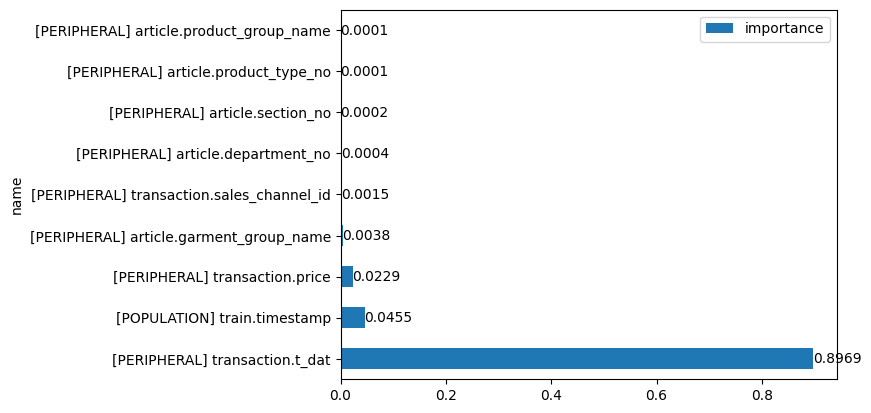

In [ ]:
# Plot the top 10 columns by importance
ax = (
    pipe.columns.sort(by="importances")[:10]
    .to_pandas()
    .assign(name=lambda c: c.marker.str.cat(c.table, sep=" ").str.cat(c.name, sep="."))
    .plot.barh(y="importance", x="name")
)
_ = ax.bar_label(ax.containers[0], fmt="%.4f")

---
## Conclusion

In this notebook, we demonstrated how to build a *time-aware, relational* model for item churn prediction using getML. We:
1. Loaded and annotated the data (population, transactions, articles, and customers),
2. Defined a DataModel to represent their relationships,
3. Applied getML's FastProp for automated feature engineering using propositionalization,
4. Trained an XGBoostRegressor to predict item-level churn,
5. Evaluated performance on validation and test sets,
6. Analyzed feature and column importances for interpretability.

This provides a solid foundation for churn prediction. While further tuning and feature engineering can enhance accuracy, this analysis highlights the strength of getML in terms of model performance, ease of use, and interpretability with minimal code.

### Next Steps
To explore model tuning or integrate custom predictors with getML's features, check out [hm-item.ipynb](hm-item.ipynb) in this repository, which focuses on item sales prediction using regression techniques.

In [ ]:
## To be integrated....

`TREND` is a function that measures how transaction dates cluster over time, indicating momentum or recency in the user's shopping behavior.

In [10]:
pred_pipe.score(container.val)
pred_pipe.score(container.test)

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:01
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building subfeatures... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 04:50
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 02:45
  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building subfeatures... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 04:46
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 02:34


,date time,set used,target,accuracy,auc,cross entropy
0,2025-01-28 17:11:28,train,churn,0.7382,0.8181,0.508
1,2025-01-28 17:19:14,val,churn,0.7454,0.824,0.504
2,2025-01-28 17:26:39,test,churn,0.7544,0.828,0.4845


In [11]:
pred_pipe.scores

,date time,set used,target,accuracy,auc,cross entropy
0,2025-01-28 17:11:28,train,churn,0.7382,0.8181,0.508
1,2025-01-28 17:19:14,val,churn,0.7454,0.824,0.504
2,2025-01-28 17:26:39,test,churn,0.7544,0.828,0.4845


In [12]:
pref = "_200"
target = "churn"

# performance on test already above human data science baseline
# but we think that there is more room with an hyperopt on top of extracted features
# next steps: select top x features, export them,
# run lightgbm hyperopt script on 200 most important features 

important_features=pred_pipe.features.sort(by='importance')[:200].names

col_export = important_features + [target]

print(len(pred_pipe.features))
    
pred_pipe.transform(container.train, df_name="train_transform")[col_export].to_parquet(fname=f"train_transform{pref}")
pred_pipe.transform(container.val,   df_name="val_transform")[col_export].to_parquet(fname=f"val_transform{pref}")
pred_pipe.transform(container.test,  df_name="test_transform")[col_export].to_parquet(fname=f"test_transform{pref}")

703
  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building subfeatures... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 04:48
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 31:36


NameError: name '_iter_batches' is not defined